# PCA 範例
* 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

In [10]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [11]:
# 定義 PCA 與隨後的邏輯斯迴歸函數
logistic = SGDClassifier(loss='log', penalty='l2', max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()

'''
class sklearn.pipeline.Pipeline(steps, memory=None)

    Pipeline of transforms with a final estimator.
    Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. 
    The final estimator only needs to implement fit. 
    The transformers in the pipeline can be cached using memory argument.
    
    The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters
    For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’
'''

# Note: 把 pca 與 logistic 用 Pipeline 串接在一起
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [12]:
# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

print(f'X_digits.shap = {X_digits.shape}, y_digits.shape = {y_digits.shape}')

X_digits.shap = (1797, 64), y_digits.shape = (1797,)


In [13]:
# 執行 GridSearchCV 跑出最佳參數

# Note: Pipeline 的特殊用法 "__" 是 delimiter
#    pca__n_components => Apply "n_components" to "pca"
#    logistic__alpha => Apply "alpha" to "logistic"
param_grid = {
    'pca__n_components': [4, 10, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}

'''
sklearn.model_selection.GridSearchCV

    Exhaustive search over specified parameter values for an estimator
    
    Important members are fit, predict.

    GridSearchCV implements a “fit” and a “score” method. 
    It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” 
    if they are implemented in the estimator used.
    
    param_grid : dict or list of dictionaries
        Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, 
        or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. 
        This enables searching over any sequence of parameter settings.
    
'''

search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.918):
{'logistic__alpha': 1.0, 'pca__n_components': 30}


pca.explained_variance_ratio_.shape=(64,)
results.shape = (35, 15)
results.head() =    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.081397      0.010592         0.000000        0.000000   
1       0.065610      0.011690         0.000000        0.000000   
2       0.068314      0.013834         0.000199        0.000399   
3       0.078902      0.012485         0.000000        0.000000   
4       0.090107      0.010532         0.000601        0.000491   
5       0.104190      0.011955         0.000999        0.000632   
6       0.130943      0.015002         0.000596        0.000487   
7       1.100906      0.586295         0.000000        0.000000   
8       0.046864      0.009879         0.000000        0.000000   
9       0.049988      0.011690         0.000000        0.000000   

  param_logistic__alpha param_pca__n_components  \
0                0.0001                       4   
1                0.0001                      10   
2                0.0001  

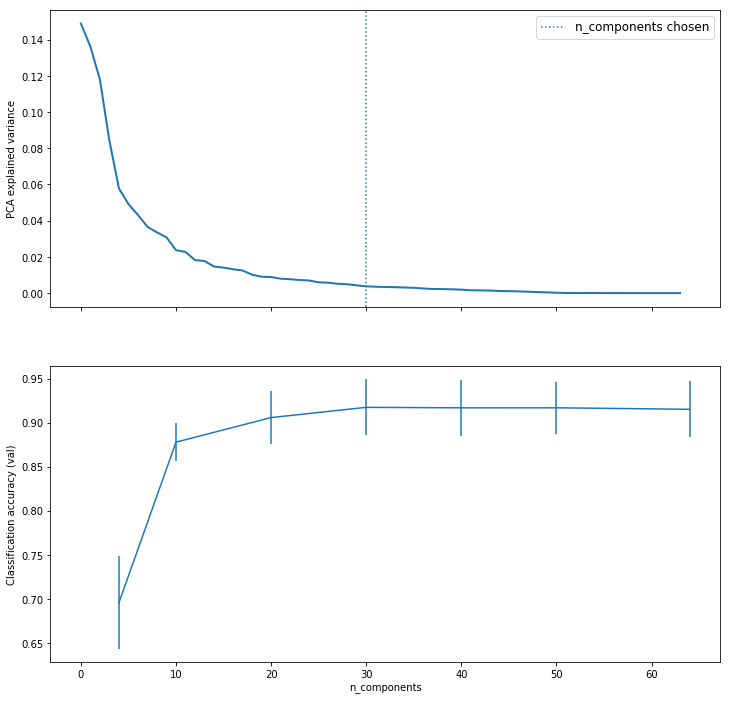

In [37]:
# 繪製不同 components 的 PCA explained variance ratio
pca.fit(X_digits)

# Erwin:
#    sharex: means share x coordinate and labels
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 12))

'''
Draw ax0
'''

print(f'pca.explained_variance_ratio_.shape={pca.explained_variance_ratio_.shape}')
# print(f'pca.explained_variance_ratio_={pca.explained_variance_ratio_}')

# explained_variance_ratio_: Percentage of variance explained by each of the selected components.
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax1.set_xlabel('n_components')

# axvline : draw vertical line
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

'''
Draw ax1
'''


# 繪製 7 個不同採樣點的 accuracy
results = pd.DataFrame(search.cv_results_)
print(f'results.shape = {results.shape}')
print(f'results.head() = {results.head(10)}')
components_col = 'param_pca__n_components'

'''
pandas.DataFrame.nlargest

    DataFrame.nlargest(n, columns, keep='first')
    
    Return the first n rows ordered by columns in descending order.
'''
# Return an Dataframe:  
#    Grouped by components_col (or 'param_pca__n_components',  or 4,10,20, ...)
#    Sort and Pick the largest y='mean_test_score'
#    Returning the dataframe is
#        x: 7 rows ('param_pca__n_components')
#        y: 15 columns (all columns from GridSearchCV)
best_clfs = results.groupby(components_col).apply(lambda d: d.nlargest(1, 'mean_test_score'))
print(f'type(best_clfs) = {type(best_clfs)}')
print(f'best_clfs.shape = {best_clfs.shape}')

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
# plt.tight_layout()

plt.show()

# 觀察結果

* explained variance ratio : 解釋變異性隨著 components 穩定下降
> Answer: 30 以後接近平緩，表示 30 個 components 是個適合的 component 數量

* 分類預測準確率 : 似乎也隨著 components 提升, 但是在 20 以後提升不多
> Answer: 30 準確率無大幅提升

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果